# Fire Detection

In this assignment, we will develop a model to detect the occurance of fires from images. We will use a dataset of images taken from various security cameras sorted into three categories: default (no fire), smoke or fire. The resulting model could be deployed to alert authorities to the location of fires captured by security cameras installed in various locations (building, shops, streets, wilderness...).

To obtain the dataset, the below cell has been prepared for you. To be able to run it, upload the shared "kaggle.json" file into the Colab virtual storage. Once ran, the dataset will be downloaded to Colab's storage in a folder called "data". Images are placed in folders named after those images' label.

Source: https://www.kaggle.com/ritupande/fire-detection-from-cctv

In [ ]:
#@title Run this to download the dataset
%%capture
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

!kaggle datasets download -d ritupande/fire-detection-from-cctv
!unzip -qn \*.zip
!rm -r /content/data/data
!rm -r /content/data/video_data

# Dataset Preparation

The first step is to prepare the images for classification. We'll start by defining a set of functions to read and process the images.

*1) Write a utility function "list_dataset" that returns:*
- *a list containing the file paths for all images in a given folder (train or test).*
- *a list containing the corresponding label for each image (taken from the folder's name.*

*2) Write a function "load_dataset" that takes the lists provided by "list_dataset" to:*
- *load all the images into memory.*
- *preprocess the images (resizing and normalizing).*
- *one-hot encode the labels.*
- *shuffle the samples.*

*3) Write a function "show_image_and_label" that displays an image along with its label and its prediction if provided (if no prediction is provided just show write a blank or "no prediction").*

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

#seed everything
SEED = 35
import tensorflow
tensorflow.random.set_seed(SEED)
np.random.seed(SEED)

#1
def _list_dataset(parent_dir: str):
    """
    Returns a list of image names (full path) and their corresponding labels from a given directory.
    """
    list_image_names_default = [parent_dir + '/default/' + dir for dir in os.listdir(parent_dir + '/default/')]
    list_labels_default = [0] * len(list_image_names_default)
    list_image_names_fire = [parent_dir + '/fire/' + dir for dir in os.listdir(parent_dir + '/fire/')]
    list_labels_fire = [2] * len(list_image_names_fire)
    list_image_names_smoke = [parent_dir + '/smoke/' + dir for dir in os.listdir(parent_dir + '/smoke/')]
    list_labels_smoke = [1] * len(list_image_names_smoke)
    image_names = list_image_names_default + list_image_names_fire + list_image_names_smoke
    labels = list_labels_default + list_labels_fire + list_labels_smoke
    return image_names, labels

#2
def load_dataset(train_path: str, test_path: str):
    """
    Returns an array containing all the images along with an array containing their corresponding labels.
    """
    #load train image names and labels
    image_names_train, labels_train = _list_dataset(train_path)
    #load test image names and labels
    image_names_test, labels_test = _list_dataset(test_path)
    #join the two subsets to have the full dataset
    image_names = image_names_train + image_names_test
    labels = labels_train + labels_test
    #one-hot encoding
    labels = np.array(labels).reshape(-1, 1)
    ohe = OneHotEncoder(sparse=False)
    labels = ohe.fit_transform(labels)
    #read and preprocess images
    images = []
    for image_name in image_names:
        img = cv2.imread(image_name)
        #we need all images to be of the same size
        img = cv2.resize(img, (224,224))
        #normalize images
        img = img / 255.0
        images.append(img)
    images = np.array(images)
    #shuffle them since we loaded them in order
    images, labels = shuffle(images, labels, random_state=SEED)
    return images, labels

#3
def show_image_and_label(X, y, idx: int, pred=None):
    if np.argmax(y[idx]) == 0:
        label = 'normal'
    elif np.argmax(y[idx]) == 1:
        label = 'smoke'
    else:
        label = 'fire'
    if pred == 0:
        pred = 'normal'
    elif pred == 1:
        pred = 'smoke'
    elif pred == 2:
        pred = 'fire'
    else:
        pred = 'None'
    plt.imshow(X[idx])
    plt.title(f'Label: {label}, Predicted: {pred}')
    plt.show()

*4) Use the function you wrote to load the dataset and split it for training and testing.*

In [ ]:
train_dir = '/content/data/img_data/train'
test_dir = '/content/data/img_data/test'

X, y = load_dataset(train_dir, test_dir)
print(X.shape, y.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=SEED)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(864, 224, 224, 3) (864, 3)
(648, 224, 224, 3) (648, 3)
(216, 224, 224, 3) (216, 3)


*5) Look at the distribution of the classes.*

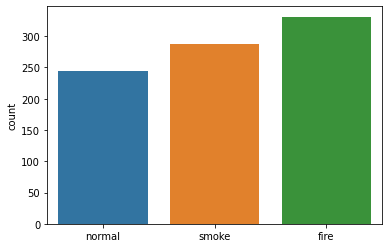

In [ ]:
import seaborn as sns

ax = sns.countplot(x=np.argmax(y, axis=1))
ax.set(xticklabels=['normal', 'smoke', 'fire']);

*6) Use the function you wrote to show one image belonging to each class.*

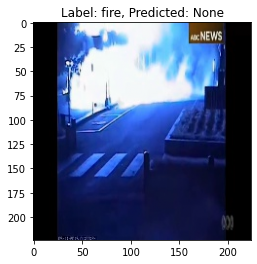

In [ ]:
show_image_and_label(X_train, y_train, 193)

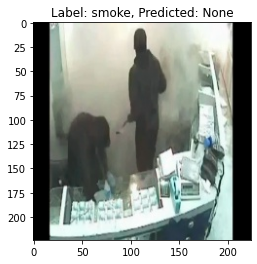

In [ ]:
show_image_and_label(X_train, y_train, 37)

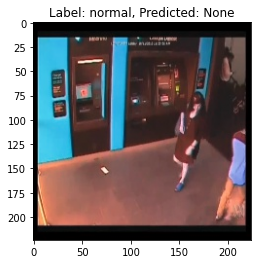

In [ ]:
show_image_and_label(X_train, y_train, 50)

# Fully Connected Neural Network

First, we will solve this classification using a fully connected neural network.

*7)*
- *Flatten the images.*
- *Build a fully connected neural network.*
- *Print the network's architecture also showing the number of trainable parameters.*
- *Train it on the data and show the training and validation loss curves. Print the value of the last training loss.*
- *Play with the different hyperparameters (number of layer, number of neurons, optimizer, regularization, epochs, batch size...) until you obtain a satisfactory behavior.*
- *Comment on the behavior of the model you obtain based on the learning curves.*

In [ ]:
#flatten the images for fc neural network
image_vector_size = 224 * 224 * 3
X_train_1d = X_train.reshape(X_train.shape[0], image_vector_size)
X_test_1d = X_test.reshape(X_test.shape[0], image_vector_size)
print(X_train_1d.shape, X_test_1d.shape)

(648, 150528) (216, 150528)


Final loss: 0.7679612040519714


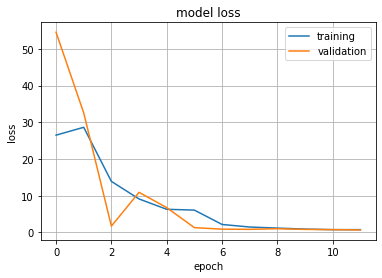

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.backend import clear_session

h_units = [256, 512, 512, 128]
out_units = 3

clear_session()
model = Sequential()
model.add(Dense(units=h_units[0], activation='relu', input_shape=(image_vector_size,)))
for u in range(1, len(h_units)):
    model.add(Dense(units=h_units[u], activation='relu'))
model.add(Dense(out_units, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_1d, y_train, batch_size=128, epochs=12, verbose=0, validation_split=0.2)

print(f"Final loss: {history.history['loss'][-1]}")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.grid()
plt.show()

The training of the model seems to have went smoothly, both the training and validation losses eventually plateuaed at a low value. There is no sign of overfitting since the loss is the same for both training and validation.

*8) Test your model on test set. Compute the accuracy. Compute the precision, recall and F1-score for each class.*

In [ ]:
y_pred = np.argmax(model.predict(X_test_1d), axis=1)

from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.51      0.67      0.58        61
           1       0.68      0.65      0.67        72
           2       0.87      0.70      0.77        83

    accuracy                           0.68       216
   macro avg       0.69      0.67      0.67       216
weighted avg       0.70      0.68      0.68       216



# Convolutional Neural Network

Now we will try to solve the same problem but using a convolutional neural network.

*9) Repeat the same steps as Question (7) above but using a CNN.*

Final loss: 0.18357619643211365


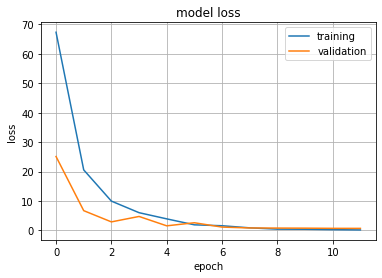

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

clear_session()
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',  input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=128, epochs=12, verbose=0, validation_split=0.2)

print(f"Final loss: {history.history['loss'][-1]}")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.grid()
plt.show()

Same as before the training went rather smoothly. However, we can see that this model converged earlier than the latter at after about 5 epochs. Also, the final loss achieved is lower.

*10) Evaluate your model showing the same metrics you showed in Question (8).*

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)

from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.86      0.69      0.76        61
           1       0.72      0.99      0.83        72
           2       0.97      0.80      0.87        83

    accuracy                           0.83       216
   macro avg       0.85      0.82      0.82       216
weighted avg       0.85      0.83      0.83       216



*11) Keeping in mind that in this problem it is very critical to detect as much fires as possible and not misclassify fires as something else, which of the metrics you computed would you be interested in more to know how good the model is at catching as many fire occurences as possible?*

The metric of interest would be recall. Recall is defined as the ratio of true positive predictions (TP) over the total number of positive samples. When considering fires, this can be interpreted as the probability of detecting a fire which is the most important task in this problem. From the scores we computed, clearly the CNN is doing better in every aspect. We also note that it has a recall of 0.8 for fires which is not bad. Interestingly, the recall for smoke is 0.99 which is really good. If we consider smoke to be an early sign of fire, this would work really well to give early warnings. However, having a very high recall with a low precision means that this model is very likely to give false alarms, this is something to watch out for.

*13) Show some examples of misclassified samples from the test set. Can you think of why the model missed those samples?*

In [ ]:
misclassified_indexes = np.where(np.not_equal(y_pred, y_test.argmax(axis=1)))[0]

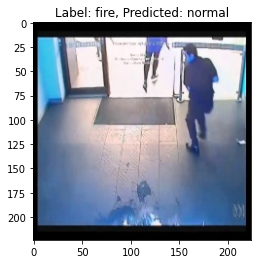

In [ ]:
i = misclassified_indexes[1]
show_image_and_label(X_test, y_test, i, y_pred[i])

Here, the fire seems at the very edge of the image and it is hard to spot.

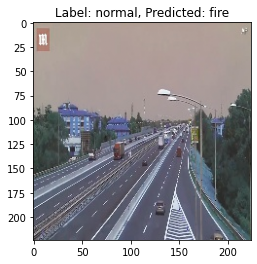

In [ ]:
i = misclassified_indexes[7]
show_image_and_label(X_test, y_test, i, y_pred[i])

There is another image of this exact same scene in the dataset but with a fire in it. Could be the reason this image was also identified as fire.

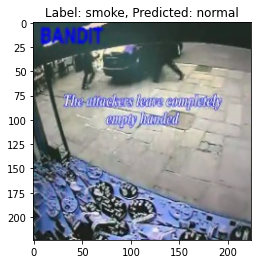

In [ ]:
i = misclassified_indexes[8]
show_image_and_label(X_test, y_test, i, y_pred[i])

I don't exactly see where the smoke is in this picture. So perhaps the labeling was inaccurate.

In general, by looking at the overall misclassified samples, the most pronouced problem is that the model is often predicting the smoke class when there is no sign of it. This is inline with the previous analysis regarding having a very high smoke recall with a lower precision.

*14) What are the advantages of using a CNN to solve an image classification problem instead of a fully connected ANN?*

- Fewer parameters to train.
- Was able to achieve better performance with a shallower architecture.
- Captures the spatial information in an image which is not taken into account in ANN.